<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-NEB-end-structures" data-toc-modified-id="Prepare-NEB-end-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare NEB end structures</a></span><ul class="toc-item"><li><span><a href="#Download-from-Materials-Project-and-create-supercell" data-toc-modified-id="Download-from-Materials-Project-and-create-supercell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download from Materials Project and create supercell</a></span></li><li><span><a href="#Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span></li><li><span><a href="#Create-and-relax-NEB-end-structures----b-and-c-directions" data-toc-modified-id="Create-and-relax-NEB-end-structures----b-and-c-directions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create and relax NEB end structures -- b and c directions</a></span></li></ul></li><li><span><a href="#NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span><ul class="toc-item"><li><span><a href="#generate-NEB-images-from-end-structures-and-conduct-NEB" data-toc-modified-id="generate-NEB-images-from-end-structures-and-conduct-NEB-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate NEB images from end structures and conduct NEB</a></span></li><li><span><a href="#analyze-and-plot-NEB-results" data-toc-modified-id="analyze-and-plot-NEB-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>analyze and plot NEB results</a></span></li><li><span><a href="#Store-NEB-images-in-one-cif-file-for-visualization" data-toc-modified-id="Store-NEB-images-in-one-cif-file-for-visualization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Store NEB images in one cif file for visualization</a></span></li><li><span><a href="#Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)" data-toc-modified-id="Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize NEB path (snapshots of VESTA visualization of path_final.cif)</a></span></li></ul></li></ul></div>


DFT barrier heights: path b = 0.27 eV and path c = 2.5 eV. (see table 1 in https://doi.org/10.1039/C5TA05062F)


In [1]:
from __future__ import annotations

from ase.neb import NEBTools
from pymatgen.ext.matproj import MPRester

from matcalc import NEBCalc, PESCalculator, RelaxCalc

mpr = MPRester('')

# Prepare NEB end structures


## Download from Materials Project and create supercell


In [2]:
s_LFPO = mpr.get_structure_by_material_id("mp-19017")
s_LFPO.make_supercell([1, 2, 2], in_place=True)
s_LFPO.to("NEB_data/LiFePO4_supercell.cif", "cif")
s_LFPO.lattice.abc, s_LFPO.formula

((10.23619605, 11.941510200000154, 9.309834380000202), 'Li16 Fe16 P16 O64')

## Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet


In [3]:
models = {
    "M3GNet-DIRECT": PESCalculator.load_universal("M3GNet-MP-2021.2.8-DIRECT-PES"),
}

/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buff

In [4]:
%%time
results = {}
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=True, fmax=0.02)
    supercell_LFPO_relaxed = relaxer.calc(s_LFPO)["final_structure"]
    results[model_name] = {"supercell_LFPO": supercell_LFPO_relaxed}

CPU times: user 33min 38s, sys: 4min 47s, total: 38min 26s
Wall time: 37 s


## Create and relax NEB end structures -- b and c directions


In [5]:
%%time
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=False, fmax=0.02)
    supercell_LFPO_relaxed = results[model_name]["supercell_LFPO"]

    # NEB path along b and c directions have the same starting image.
    s_LFPO_end_b = supercell_LFPO_relaxed.copy()
    s_LFPO_end_b.remove_sites([11])
    s_LFPO_end_b_relaxed = relaxer.calc(s_LFPO_end_b)["final_structure"]
    s_LFPO_end_c = supercell_LFPO_relaxed.copy()
    s_LFPO_end_c.remove_sites([4])
    s_LFPO_end_c_relaxed = relaxer.calc(s_LFPO_end_c)["final_structure"]
    s_LFPO_start_bc = supercell_LFPO_relaxed.copy()
    s_LFPO_start_bc.remove_sites([5])
    s_LFPO_start_bc_relaxed = relaxer.calc(s_LFPO_start_bc)["final_structure"]
    results[model_name].update(
        {
            "supercell_LFPO_end_b": s_LFPO_end_b_relaxed,
            "supercell_LFPO_end_c": s_LFPO_end_c_relaxed,
            "supercell_LFPO_start_bc": s_LFPO_start_bc_relaxed,
        }
    )

CPU times: user 36min 29s, sys: 5min 19s, total: 41min 48s
Wall time: 40 s


# NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet

The universal potentials provide reasonable agreement with each other and with literature.

References:

1. https://pubs.rsc.org/en/content/articlelanding/2011/ee/c1ee01782a
2. https://doi.org/10.1103/PhysRevApplied.7.034007


## generate NEB images from end structures and conduct NEB


In [6]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        # Instantiate the NEBCalc object with the desired parameters
        neb_calc = NEBCalc(
            calculator=model,
            optimizer="BFGS",  # Specify the optimizer if different from default
            traj_folder=f"NEB_data/traj_{neb_path}_{model_name}/",
            climb=True,
            fmax=0.05,
            max_steps=1000,  # Specify max_steps if different from default
            get_mep = True,
        )

        results_dict = neb_calc.calc_images(
            start_struct=results[model_name]["supercell_LFPO_start_bc"],
            end_struct=results[model_name][f"supercell_LFPO_end_{neb_path}"],
            n_images=7,
            interpolate_lattices=False,
            autosort_tol=0.5
        )

        barrier = results_dict["barrier"]
        results[model_name][f"mep_{neb_path}"] = results_dict
        results[model_name][f"NEB_{neb_path}"] = neb_calc.neb
        print(f"Barrier along {neb_path} by {model_name}: {barrier} eV.")

/global/cfs/cdirs/matgen/zihanyu/repos/matcalc/src/matcalc/_neb.py:126: FutureWarning: Please import NEB from ase.mep, not ase.neb.
  self.neb = NEB(images, climb=self.climb, allow_shared_calculator=True, **self.kwargs)


      Step     Time          Energy          fmax
BFGS:    0 19:59:34     -756.271179        1.814604
BFGS:    1 19:59:44     -756.389038        1.204931
BFGS:    2 19:59:54     -756.550476        0.738625
BFGS:    3 20:00:05     -756.628662        0.546136
BFGS:    4 20:00:17     -756.659546        0.469007
BFGS:    5 20:00:28     -756.668762        0.463851
BFGS:    6 20:00:37     -756.680420        0.449385
BFGS:    7 20:00:46     -756.698303        0.431233
BFGS:    8 20:00:57     -756.719238        0.316627
BFGS:    9 20:01:07     -756.732666        0.302804
BFGS:   10 20:01:17     -756.739075        0.311124
BFGS:   11 20:01:28     -756.747681        0.312035
BFGS:   12 20:01:39     -756.758362        0.260896
BFGS:   13 20:01:49     -756.771912        0.283065
BFGS:   14 20:02:00     -756.785095        0.267567
BFGS:   15 20:02:10     -756.792786        0.234137
BFGS:   16 20:02:21     -756.797546        0.225235
BFGS:   17 20:02:32     -756.802856        0.180441
BFGS:   18 20:

/global/cfs/cdirs/matgen/zihanyu/repos/matcalc/src/matcalc/_neb.py:138: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.
  neb_tool = NEBTools(self.neb.images)


Barrier along b by M3GNet-DIRECT: 0.15753173828125044 eV.
      Step     Time          Energy          fmax
BFGS:    0 20:06:28     -755.308777        4.671041
BFGS:    1 20:06:42     -755.583313        1.754299
BFGS:    2 20:06:54     -755.708313        1.327226
BFGS:    3 20:07:04     -755.897278        0.831179
BFGS:    4 20:07:16     -755.949951        0.620293
BFGS:    5 20:07:25     -755.975037        0.663202
BFGS:    6 20:07:35     -755.987854        0.544540
BFGS:    7 20:07:44     -756.006287        0.422392
BFGS:    8 20:07:54     -756.031494        0.285040
BFGS:    9 20:08:05     -756.050659        0.259624
BFGS:   10 20:08:16     -756.059631        0.311854
BFGS:   11 20:08:26     -756.064087        0.284365
BFGS:   12 20:08:37     -756.067200        0.237914
BFGS:   13 20:08:46     -756.071960        0.184257
BFGS:   14 20:08:56     -756.077881        0.125517
BFGS:   15 20:09:07     -756.081482        0.133482
BFGS:   16 20:09:19     -756.083679        0.115893
BFGS:   

## analyze and plot NEB results


Path along b, M3GNet-DIRECT: 


<timed exec>:5: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.


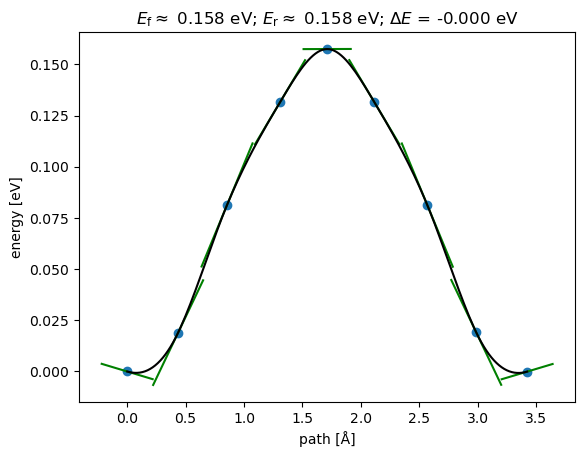

Path along c, M3GNet-DIRECT: 


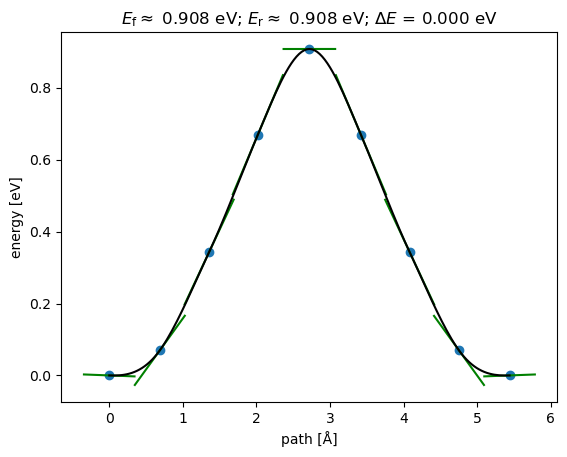

CPU times: user 14min 6s, sys: 1min 53s, total: 16min
Wall time: 16.5 s


In [7]:
%%time
import matplotlib.pyplot as plt

for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        print(f"Path along {neb_path}, {model_name}: ")
        fig = NEB_tool.plot_band()
        plt.show()

## Store NEB images in one cif file for visualization


In [8]:
from itertools import chain

from pymatgen.core import PeriodicSite, Structure
from pymatgen.io.ase import AseAtomsAdaptor


def generate_path_cif_from_images(images: list, filename: str) -> None:
    """Generate a cif file from a list of image atoms."""
    image_structs = [AseAtomsAdaptor.get_structure(image) for image in images]
    sites = set()
    lattice = image_structs[0].lattice
    sites.update(
        PeriodicSite(site.species, site.frac_coords, lattice) for site in chain(*(struct for struct in image_structs))
    )
    neb_path = Structure.from_sites(sorted(sites))
    neb_path.to(filename, "cif")

In [9]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        generate_path_cif_from_images(NEB_tool.images, f"NEB_data/traj_{neb_path}_{model_name}/path_final.cif")

<timed exec>:3: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.


CPU times: user 12.6 s, sys: 531 ms, total: 13.1 s
Wall time: 12.6 s


## Visualize NEB path (snapshots of VESTA visualization of path_final.cif)


In [10]:
from IPython.display import Image

Final path b by M3GNet-DIRECT:


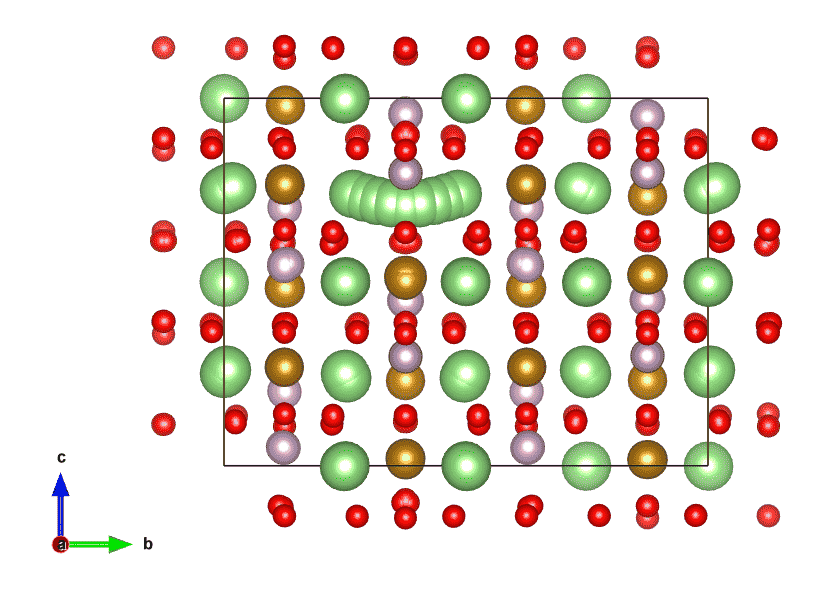

In [11]:
print("Final path b by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-b.png")

Final path c by M3GNet-DIRECT:


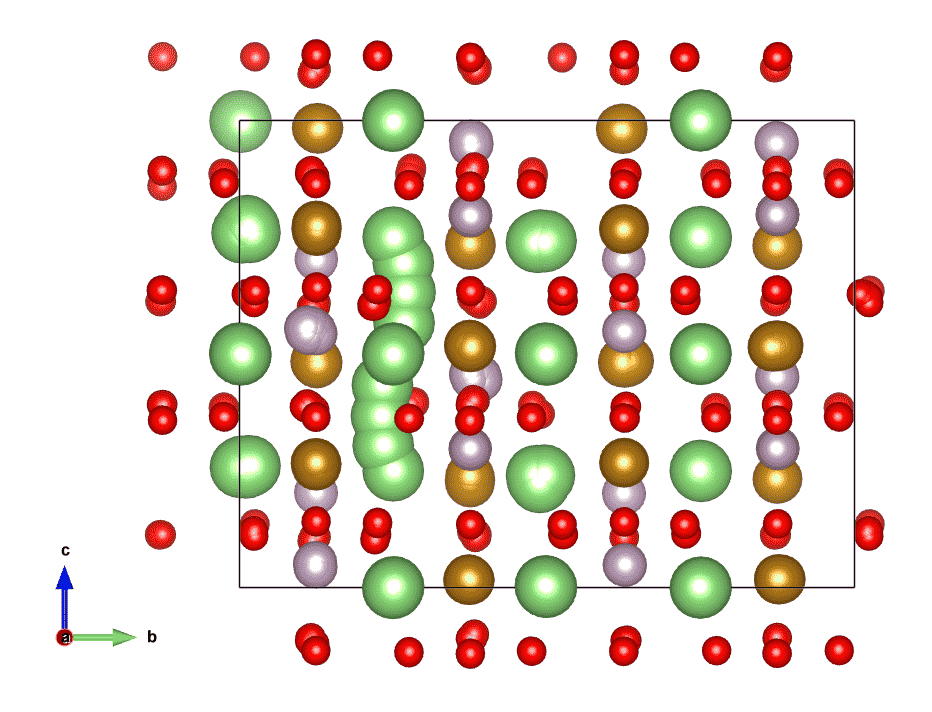

In [12]:
print("Final path c by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-c.png")